# Loading files

In [1]:
import pandas as pd
import os
import scipy.stats as stats
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from settings import data_folder,preprocessed_folder
%load_ext autoreload
%autoreload 2

Load the world governance index

In [2]:
dfs = pd.ExcelFile(os.path.join(data_folder, "wgidataset.xlsx"))
sheet_names = dfs.sheet_names[1:]  # Remove introduction


In [3]:
for i in range(6):
    sheet_name = sheet_names[i]
    indexwgi = pd.read_excel(
        os.path.join(data_folder, "wgidataset.xlsx"),
        sheet_name=sheet_name,
        header=[13, 14],
    )
    # Select only countries
    countries = indexwgi.xs("Country/Territory", axis=1, level=1).rename(
        columns={"Unnamed: 0_level_0": "Country"}
    )
    # Select only estimates
    indexwgi = pd.concat(
        (countries, indexwgi.xs("Estimate", axis=1, level=1)), axis=1
    ).set_index("Country")
    # Convert to uniform distribution using the normal CFD (because CDF(X)~Unif if X~Norm)
    indexwgi_uniform = indexwgi.copy()
    indexwgi_uniform.iloc[:, :] = stats.norm.cdf(indexwgi)
    indexwgi_uniform.loc["Other"] = indexwgi_uniform.mean(axis=0, numeric_only=True)
    indexwgi_uniform.loc["Gibraltar"] = indexwgi_uniform.loc["United Kingdom"]
    indexwgi_uniform.to_csv(
        os.path.join(preprocessed_folder, f"wgidataset_{sheet_name}.csv"), index=True
    )


## Extraction Democracy index
Extraction from Wikipedia table

In [4]:
# Get the response in the form of html
wikiurl = "https://en.wikipedia.org/wiki/Democracy_Index"
response = requests.get(wikiurl)
print(response.status_code)


200


In [5]:
soup = BeautifulSoup(response.text, "html.parser")
democracy_index_table = soup.find_all("table", {"class": "wikitable"})[
    3
]  # 4th table in page
df = pd.read_html(str(democracy_index_table))
# Convert list to dataframe
df = pd.DataFrame(df[0])
df


,Region,2021 rank,Country,Regime type,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2008,2006
0,North America,12,Canada,Full democracy,8.87,9.24,9.22,9.15,9.15,9.15,9.08,9.08,9.08,9.08,9.08,9.08,9.07,9.07
1,North America,26,United States,Flawed democracy,7.85,7.92,7.96,7.96,7.98,7.98,8.05,8.11,8.11,8.11,8.11,8.18,8.22,8.22
2,Western Europe,21,Austria,Full democracy,8.07,8.16,8.29,8.29,8.42,8.41,8.54,8.54,8.48,8.62,8.49,8.49,8.49,8.69
3,Western Europe,36,Belgium,Flawed democracy,7.51,7.51,7.64,7.78,7.78,7.77,7.93,7.93,8.05,8.05,8.05,8.05,8.16,8.15
4,Western Europe,37,Cyprus,Flawed democracy,7.43,7.56,7.59,7.59,7.59,7.65,7.53,7.40,7.29,7.29,7.29,7.29,7.70,7.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Sub-Saharan Africa,92,Tanzania,Hybrid regime,5.10,5.10,5.16,5.41,5.47,5.76,5.58,5.77,5.77,5.88,5.64,5.64,5.28,5.18
163,Sub-Saharan Africa,136,Togo,Authoritarian,2.80,2.80,3.30,3.10,3.05,3.32,3.41,3.45,3.45,3.45,3.45,3.45,2.43,1.75
164,Sub-Saharan Africa,100,Uganda,Hybrid regime,4.48,4.94,5.02,5.20,5.09,5.26,5.22,5.22,5.22,5.16,5.13,5.05,5.03,5.14
165,Sub-Saharan Africa,79,Zambia,Hybrid regime,5.72,4.86,5.09,5.61,5.68,5.99,6.28,6.39,6.26,6.26,6.19,5.68,5.25,5.25


In [6]:
# Save file
df.to_csv(os.path.join(preprocessed_folder, "democracy_index.csv"), index=False)


In [9]:
democracy_index = (
    pd.read_csv(os.path.join(preprocessed_folder, "democracy_index.csv"))
    .drop(columns=["Regime type", "2021 rank", "Region"])
    .sort_values("Country")
    .reset_index(drop=True)
)
# Normalization between 0 and 1
democracy_index = democracy_index.set_index("Country") / 10
# Compute the index on some regions
eu_index = (
    pd.read_csv(os.path.join(preprocessed_folder, "democracy_index.csv"))
    .drop(columns=["Regime type", "2021 rank"])
    .groupby("Region")
    .mean(numeric_only=True)
)
eu_index = eu_index.loc["Western Europe"]
world_index = (
    pd.read_csv(os.path.join(preprocessed_folder, "democracy_index.csv"))
    .drop(columns=["Regime type", "2021 rank"])
    .mean(numeric_only=True)
)
democracy_index = pd.concat(
    (
        democracy_index,
        eu_index.to_frame("EU").T / 10,
        world_index.to_frame("Other").T / 10,
    ),
    axis=0,
)
# Filter between 2010 and 2020
democracy_index_10_20 = democracy_index[[str(i) for i in range(2010, 2021)]].copy()
democracy_index_10_20.loc["Gibraltar"] = democracy_index_10_20.loc["United Kingdom"]
democracy_index_10_20.to_csv(
    os.path.join(preprocessed_folder, "democracy_index_10_20.csv"), index=True
)


# Gas import and export
Extract the gas import/export/production from the Eurostat's xlsx files.

#### Production

In [10]:
# Countries to remove (no data available)
remove_country = [
    "Liechtenstein",
    "Bosnie-Herzégovine",
    "Géorgie",
    "Albanie",
    "Chypre",
    "Malte",
    "Islande",
    "Monténégro",
    "Kosovo (selon la résolution 1244/99 du Conseil de sécurité des Nations Unies)",
]


In [11]:
conversion_tep_tj = 41.868  # https://fr.wikipedia.org/wiki/Tonne_d%27équivalent_pétrole
production_euro_country = pd.read_excel(
    os.path.join(data_folder, "eurostat", "gas_prod.xlsx"),
    sheet_name="Feuille 1",
    skiprows=9,
    header=0,
    nrows=43,
    na_values=":",
).rename(columns={"TIME": "Country"})
production_euro_country = (
    production_euro_country.drop([0, 1, 2])
    .set_index("Country")
    .drop(remove_country[1:])
)  # Liechtenstein, is not in the table
# Replace missing value by the mean over the last 3 years
countries_missing = ["Norvège", "Royaume-Uni", "Serbie", "Turquie", "Moldavie"]
production_euro_country.loc[countries_missing, "2020"] = production_euro_country.loc[
    countries_missing,
    ["2018", "2019", "2020"],
].mean(axis=1)

# Replace all the remaining missing values with 0's
production_euro_country = production_euro_country.fillna(0)
production_euro_country *= conversion_tep_tj
# Save as csv
production_euro_country.to_csv(os.path.join(preprocessed_folder, "gas_prod.csv"))


#### Exports

In [12]:
# Name of the excel sheets
# Remove warning concerning no default style set, apply openpyxl's default
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    name_sheet = pd.read_excel(
        os.path.join(data_folder, "eurostat", "gas_export.xlsx"),
        sheet_name="Sommaire",
        skiprows=14,
        usecols=[1, 2, 3, 4, 5],
    ).set_index("Contenus")


In [13]:
export_df = None
for i in range(1, 23):
    sh_name = f"Feuille {i}"
    current_sheet = name_sheet.loc[sh_name]

    with warnings.catch_warnings(record=True):
        warnings.simplefilter("always")
        export_ = (
            pd.read_excel(
                os.path.join(data_folder, "eurostat", "gas_export.xlsx"),
                sheet_name=sh_name,
                usecols=["PARTNER (Libellés)", "Suisse"],
                skiprows=9,
                header=0,
                nrows=45,
                na_values=":",
                engine="openpyxl",
            )
            .drop([0, 1, 2, 3])
            .rename(columns={"PARTNER (Libellés)": "Country_export"})
            .set_index("Country_export")
            .drop(remove_country)
        )
    col = "Classification internationale standard des produits de l'énergie (SIEC)"
    export_.columns = pd.MultiIndex.from_arrays(
        [
            [current_sheet[col]],
            [str(current_sheet.Temps)],
        ],
        names=["Type", "Year"],
    )
    if export_df is None:
        export_df = export_.copy()
    else:
        export_df = pd.concat((export_df, export_), axis=1)
print("How many missing values?", export_df.isnull().sum().sum())
export_df = export_df.fillna(0)
export_df.to_csv(os.path.join(preprocessed_folder, "gas_export_to_ch.csv"))


How many missing values? 2


#### Imports

In [14]:
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    name_sheet = pd.read_excel(
        os.path.join(data_folder, "eurostat", "gas_import.xlsx"),
        sheet_name="Sommaire",
        skiprows=14,
        usecols=[1, 2, 3, 4, 5],
    ).set_index("Contenus")


In [15]:
import_df = pd.DataFrame()
cols = [
    "Autre(s) pays européen(s) (agrégat variable en fonction du contexte)",
    "Autre(s) pays composant anciennement l'Union Soviétique (avant 1991)",
    "Autre(s) pays d'Afrique (agrégat variable en fonction du contexte)",
    "Autre(s) pays d'Amérique (agrégat variable en fonction du contexte)",
    "Autre(s) pays du Proche et Moyen-Orient",
    "Autre(s) pays d'Asie (agrégat variable en fonction du contexte)",
]
for i in range(1, 23):
    sh_name = f"Feuille {i}"
    current_sheet = name_sheet.loc[sh_name]

    with warnings.catch_warnings(record=True):
        warnings.simplefilter("always")
        import_ = (
            pd.read_excel(
                os.path.join(data_folder, "eurostat", "gas_import.xlsx"),
                sheet_name=sh_name,
                skiprows=9,
                header=0,
                nrows=45,
                na_values=":",
                engine="openpyxl",
            )
            .drop([0, 1, 2, 3])
            .drop(columns=cols)
            .rename(columns={"PARTNER (Libellés)": "Country_import"})
            .set_index("Country_import")
            .drop(remove_country)
        )
    import_["Year"] = str(current_sheet.Temps)
    col = "Classification internationale standard des produits de l'énergie (SIEC)"
    import_["Type"] = current_sheet[col]

    import_df = pd.concat((import_df, import_), axis=0)
print(
    "How many missing values?",
    import_df[import_df.Type == "Gaz naturel"].isnull().sum().sum(),
)


How many missing values? 160


In [16]:
import_gaz_nat = import_df[import_df.Type == "Gaz naturel"]
for ind, r in import_gaz_nat.iterrows():
    if r.isnull().sum() > 0:
        print(r[r.isnull()])
# 1 missing value for (Italy,Non spécifié)
# 159 missing values for (UK,all other countries) in 2020 (Brexit)


Non spécifié    NaN
Name: Italie, dtype: object
Belgique                                                  NaN
Bulgarie                                                  NaN
Tchéquie                                                  NaN
Danemark                                                  NaN
Allemagne (jusqu'en 1990, ancien territoire de la RFA)    NaN
                                                         ... 
Nouvelle-Calédonie (FR)                                   NaN
Papouasie - Nouvelle-Guinée                               NaN
Îles Marshall                                             NaN
Total                                                     NaN
Non spécifié                                              NaN
Name: Royaume-Uni, Length: 159, dtype: object


Deal with missing data. In particular no data is provided for 2020 for the UK (Brexit). We use the average value of the previous 3 years.

In [17]:
import_uk = import_df.loc["Royaume-Uni"].copy()
import_2020_avg = (
    import_uk[import_uk.Year.isin(["2017", "2018", "2019"])]
    .groupby("Type")
    .mean(numeric_only=True)
    .reset_index()
)
import_2020_avg["Year"] = "2020"
import_2020_avg["Country_import"] = "Royaume-Uni"
import_2020_avg.set_index("Country_import", inplace=True)
# Sort the order of the columns so it match the one of "import_uk"
import_2020_avg = import_2020_avg[import_uk.columns].copy()
import_uk[import_uk.Year == "2020"] = import_2020_avg
import_df.loc["Royaume-Uni"] = import_uk
import_df = import_df.fillna(0)
import_df.to_csv(os.path.join(preprocessed_folder, "gas_import.csv"))


#### Stocks

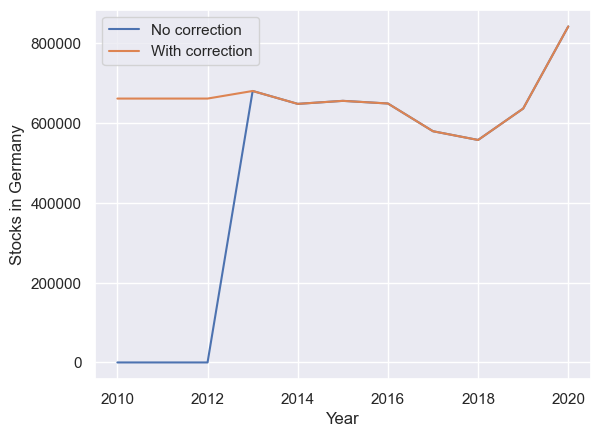

In [18]:
sns.set()

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    sh_name = "Feuille 1"
    stocks = (
        pd.read_excel(
            os.path.join(data_folder, "eurostat", "stocks.xlsx"),
            sheet_name=sh_name,
            skiprows=9,
            header=0,
            nrows=45,
            na_values=":",
            engine="openpyxl",
        )
        .drop([0, 1, 2, 3])
        .rename(columns={"TIME": "Country_stock"})
        .set_index("Country_stock")
        .drop(remove_country)
    )
stocks.fillna(0, inplace=True)
# Issue with germany between 2010 and 2012
germany = "Allemagne (jusqu'en 1990, ancien territoire de la RFA)"
stocks.loc[germany].plot(label="No correction")
# Replace by the mean
stocks.loc[germany, ["2010", "2011", "2012"]] = stocks.loc[
    germany, ["2013", "2014", "2015"]
].mean()
stocks.loc[germany].plot(label="With correction")
plt.ylabel("Stocks in Germany")
plt.xlabel("Year")
plt.legend()


In [19]:
stocks.to_csv(os.path.join(preprocessed_folder,"stocks.csv"))

# Export to CH

In [20]:
# Manually corrected value from experts
export_to_ch = pd.DataFrame(
    {
        "France": [41, 29, 31, 32, 20, 30, 36, 56, 59],
        "Italie": [3, 3, 3, 3, 3, 3, 3, 3, 3],
        "Allemagne (jusqu'en 1990, ancien territoire de la RFA)": [
            56,
            68,
            66,
            65,
            77,
            67,
            60,
            41,
            38,
        ],
        "Year": range(2012, 2021),
    }
)
export_to_ch.to_csv(os.path.join(preprocessed_folder, "export_to_ch.csv"), index=False)
